# Spherical latent space model for Networks: Model $\mathbb{S}^2$

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.SphericalM import *
from Modules.SphericalV import *
from Modules.SphericalC import *

## Network

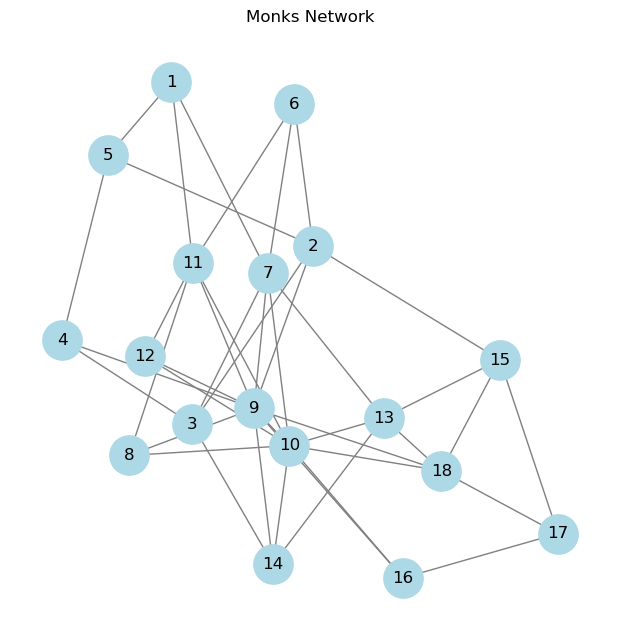

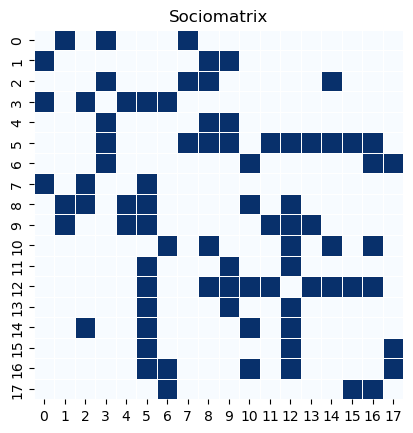

In [2]:
import zipfile
from io import BytesIO as StringIO

with zipfile.ZipFile("sampson_data.zip") as zf:
    g = StringIO(zf.read("samplike1.txt"))

G = nx.read_edgelist(g, delimiter="\t")
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Monks Network")
plt.show()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix")
plt.show()

## Latent space

### Frequentist inference

Initial log-likelihood: -297.9353926514068
Final log-likelihood: -148.57083616398063
Final alpha: -1.342746785260526


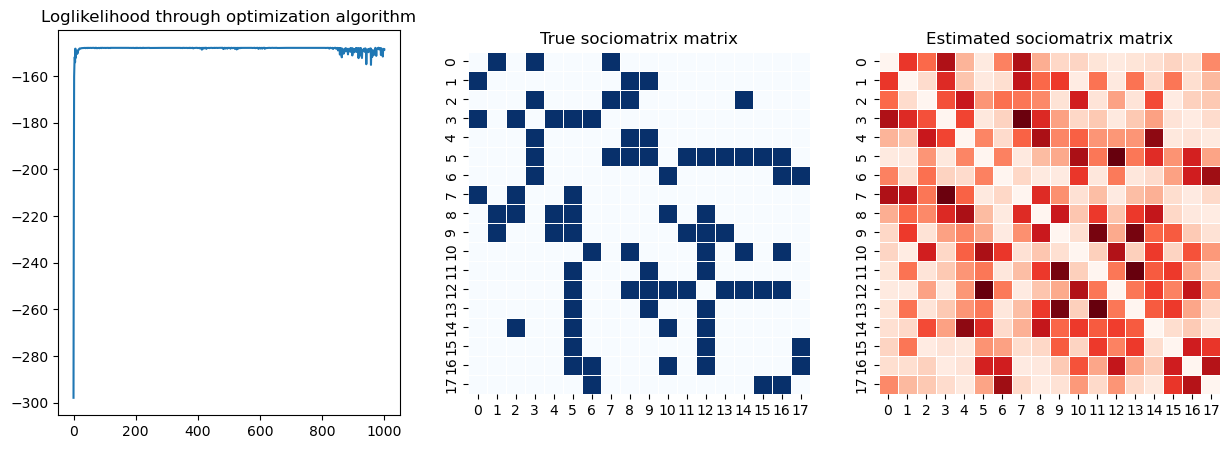

In [3]:

inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)
Z_init = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a_init = np.float64(np.random.randn())
b_init = np.float64(np.random.randn())
Z_ML, a_ML, b_ML, historyZ, historya, historyb  =  SearchingMLE(G,Z_init,a_init,b_init,1000)
print("Initial log-likelihood:", loglikelihood(G,Z_init,a_init,b_init))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Final alpha:", a_ML)
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = Z_ML[i].T @ Z_ML[j]
            Y_ML[i,j] = expit(a_ML + b_ML*d)


df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = df.index 
fig = px.scatter_3d(
    df, x='x', y='y', z='z',color_discrete_sequence=["blue"], opacity=0.7,
    hover_data={'node': True,'x': ':.2f','y': ':.2f','z': ':.2f'})

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1.1, 1.1]),yaxis=dict(range=[-1.1, 1.1]),zaxis=dict(range=[-1.1, 1.1]),
        aspectmode='cube'),
    title="Maximum likelihood estimation of latent positions")

fig.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([loglikelihood(G, historyZ[t],historya[t],historyb[t]) for t in range(len(historya))])
plt.title("Loglikelihood through optimization algorithm")
plt.subplot(1,3,2)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,3,3)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

### Bayesian inference

In [4]:
# Execute HMC
number_of_samples = 5000
Z_init = Z_ML.copy()
a_init = a_ML
b_init = b_ML


print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init,b_init))

samples_Z, samples_a, samples_b, Hp, LogLp, acep_rate_history = ghmc(G, Z_init, a_init, b_init, number_of_samples, epsilon_init=0.1, 
                                                                     std_dev_init_Z=0.2, std_dev_init_a = 1.0, std_dev_init_b = 0.5, 
                                                                     percentage_warmup=0.01)
samples_Z = [compute_starS2(samples_Z[i],Z_ML) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)
# Estimators
## CM
from scipy.stats import circmean
inclination_angles_CM = circmean(np.arccos(samples_Z[:,:,2]), high=np.pi, low=0,axis=0)
azimutal_angles_CM = circmean(np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0]), high=2*np.pi, low=0,axis=0)
Z_CM = np.stack((np.sin(inclination_angles_CM) * np.cos(azimutal_angles_CM),
                       np.sin(inclination_angles_CM) * np.sin(azimutal_angles_CM),
                       np.cos(inclination_angles_CM)), axis=1)
a_CM = np.mean(samples_a, axis=0)
b_CM = np.mean(samples_b, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]
b_MAP = samples_b[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP,b_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM,b_CM))

Log-L MLE: -148.57083616398063
Log-L starter: -148.57083616398063
Number of samples: 5000
Number of parameters: 20
Number of iterations: 5050
Number of warmup iterations: 50


  1%|          | 50/5050 [00:34<1:06:15,  1.26it/s]

Final parameters: epsilon=0.0790, L=13, std_dev_Z=0.1580, std_dev_a=1.0000, std_dev_b=0.5000


100%|██████████| 5050/5050 [56:55<00:00,  1.48it/s] 


Acceptance rate: 0.13710


c:\Users\carlo\OneDrive\Documents\LatentSpaces_Network_Manifold\Modules\SphericalM.py:205: RuntimeWarning:

invalid value encountered in arccos



Log-L MAP: -159.51212724091113
Log-L CM: nan


c:\Users\carlo\OneDrive\Documents\LatentSpaces_Network_Manifold\Modules\SphericalM.py:26: RuntimeWarning:

invalid value encountered in logaddexp

c:\Users\carlo\OneDrive\Documents\LatentSpaces_Network_Manifold\Modules\SphericalM.py:28: RuntimeWarning:

invalid value encountered in logaddexp



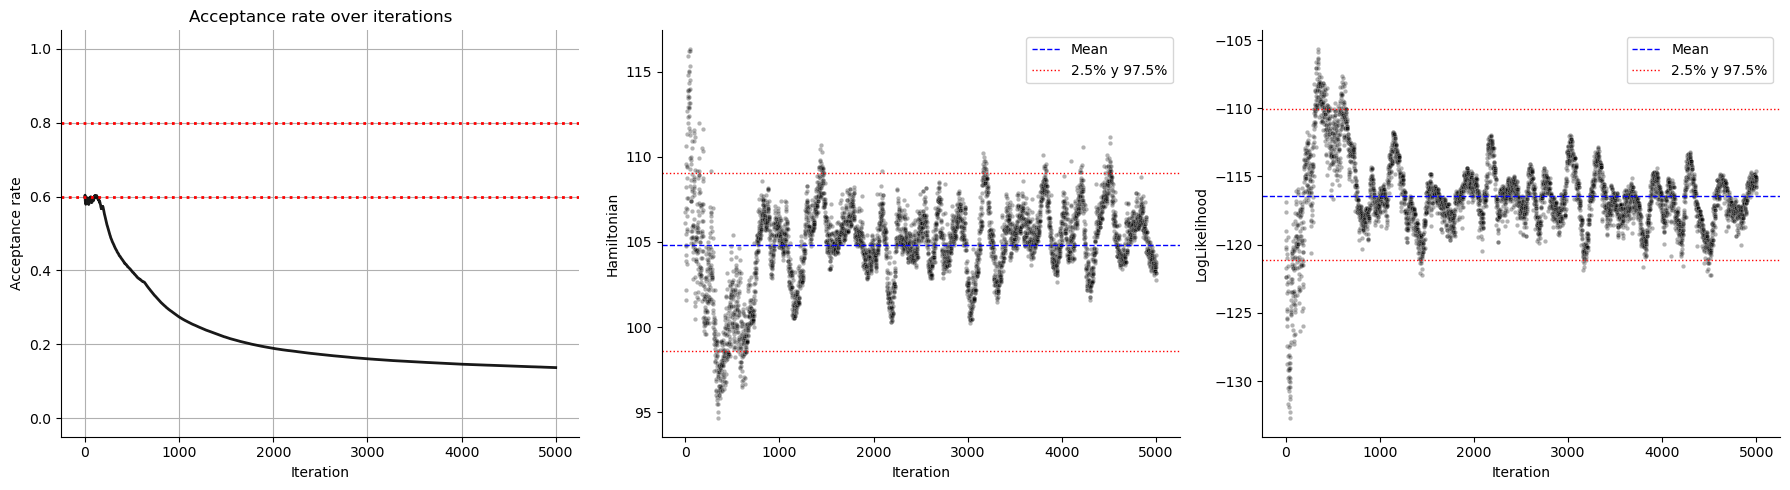

In [5]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

In [6]:
plot_Z_samples_3D(samples_Z[:50])

ValueError: autodetected range of [nan, nan] is not finite

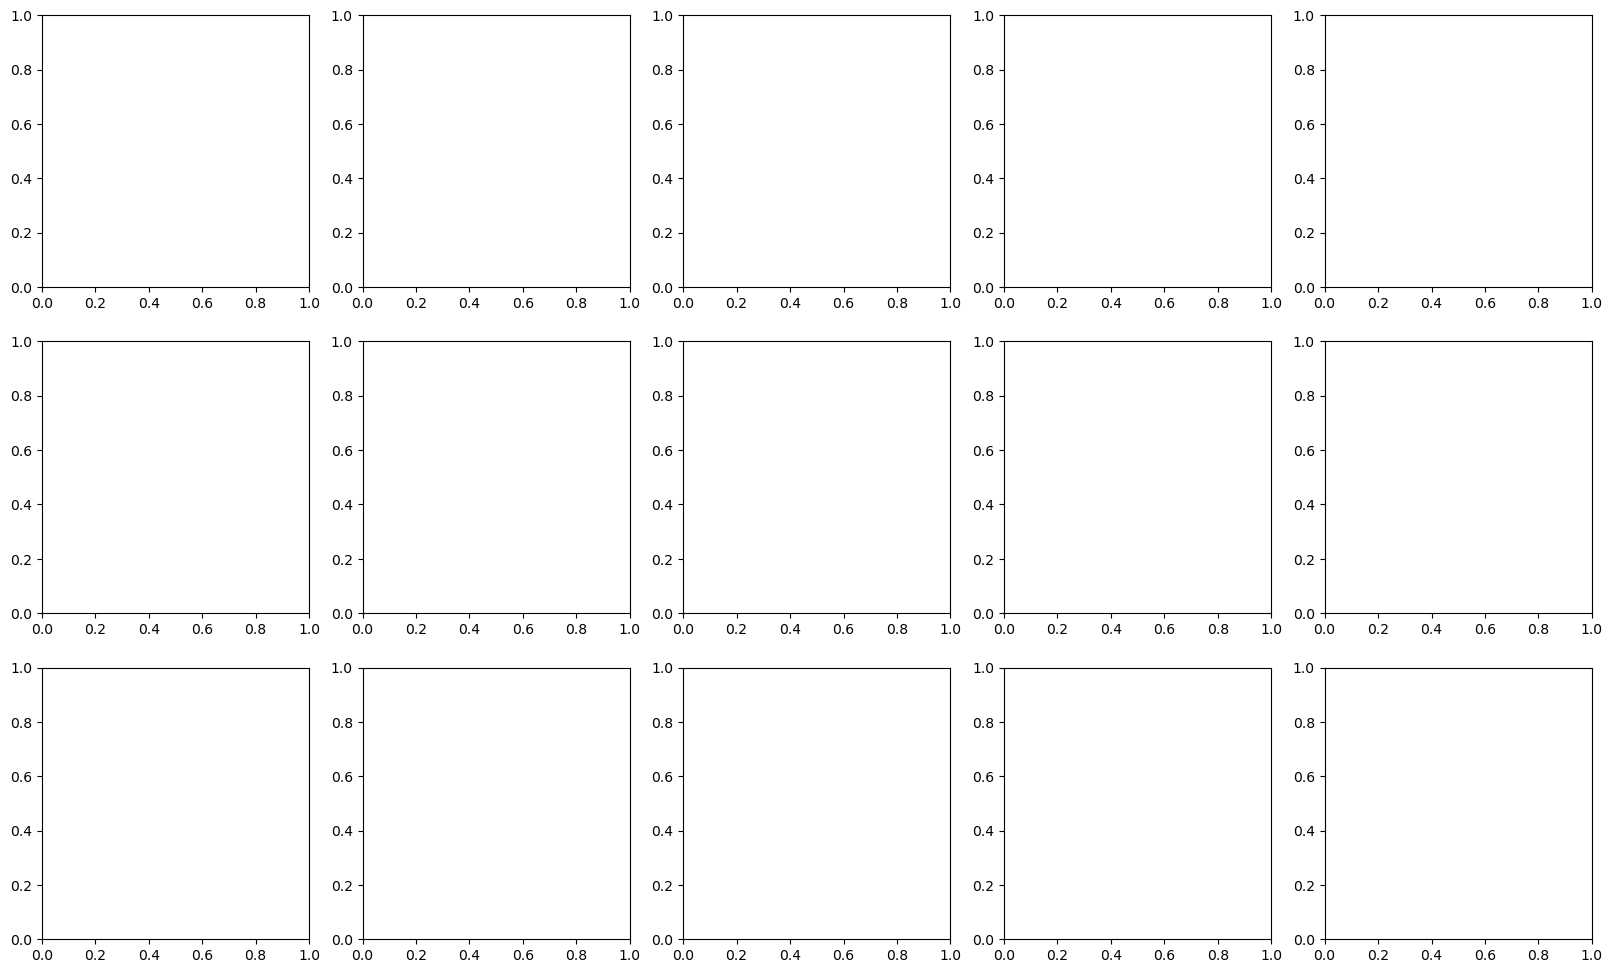

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  
axes = axes.flatten()
for i in range(15):
    ax = axes[i]
    samples_i = samples_Z[:, i, :]  
    phi = np.mod(np.arctan2(samples_i[:,1], samples_i[:,0]), 2*np.pi)   
    theta = np.mod(np.arccos(samples_i[:,2]), np.pi)  
    h = ax.hist2d(phi, theta, bins=(25, 25), cmap='Greys')
    phi_cm = np.mod(np.arctan2(Z_CM[i,1], Z_CM[i,0]), 2*np.pi)
    theta_cm = np.arccos(Z_CM[i,2])
    phi_map = np.mod(np.arctan2(Z_MAP[i,1], Z_MAP[i,0]), 2*np.pi)
    theta_map = np.arccos(Z_MAP[i,2])
    ax.plot(phi_cm, theta_cm, 'bo', label='CM')
    ax.plot(phi_map, theta_map, 'ro', label='MAP')
    ax.set_title(f'Node {i}')
    ax.set_xlabel(r'polar')
    ax.set_ylabel(r'inclination')
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels(['0', r'$\pi/2$', r'$\pi$'])
handles = [plt.Line2D([0], [0], marker='o', color='w', label='CM', markerfacecolor='b'),
           plt.Line2D([0], [0], marker='o', color='w', label='MAP', markerfacecolor='r')]
fig.legend(handles=handles, loc='upper right')
plt.tight_layout()
plt.suptitle("Histograms of polar and inclination for each node", y=1.03, fontsize=18)
plt.show()


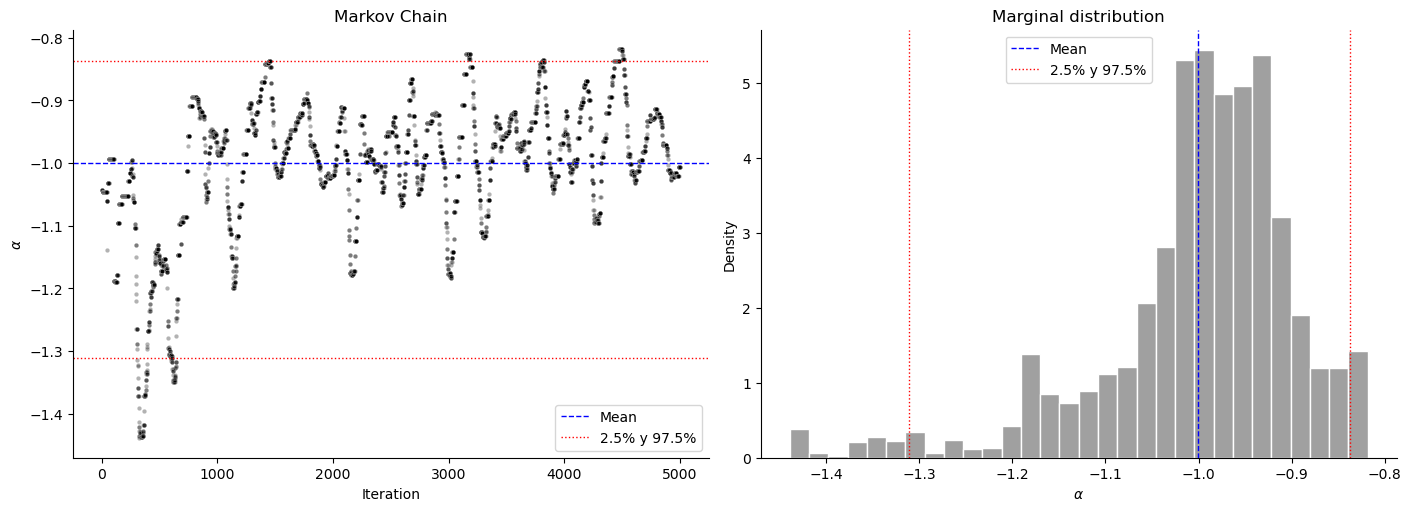

In [8]:
plot_alpha(samples_a)

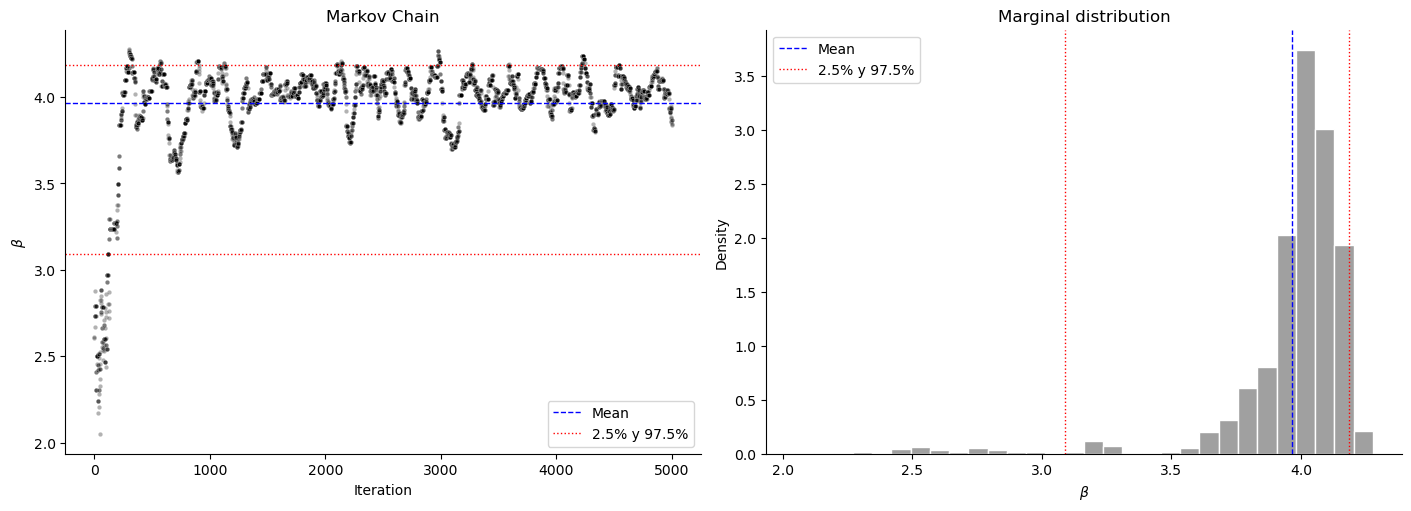

In [9]:
plot_beta(samples_b)

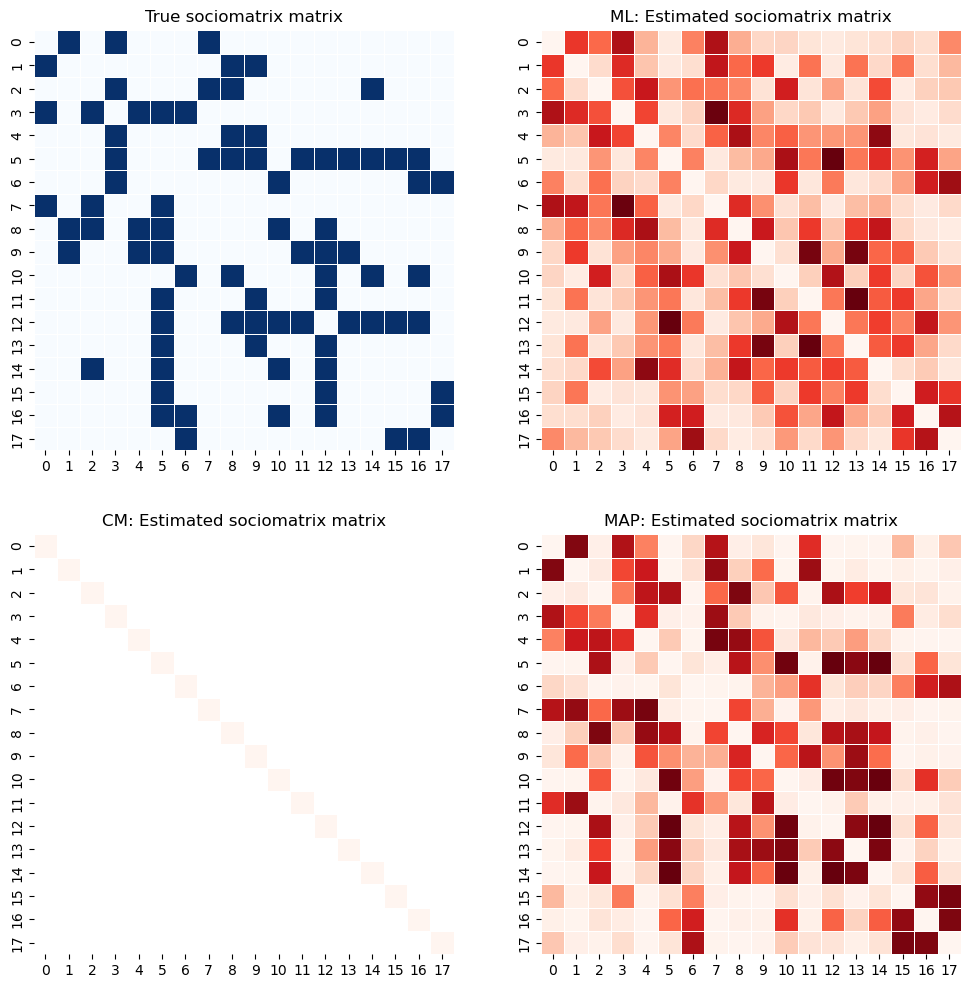

In [10]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_CM[i].T @ Z_CM[j]
            Y_CM[i,j] = expit(a_CM + b_CM * dist)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_MAP[i].T @ Z_MAP[j]
            Y_MAP[i,j] = expit(a_MAP + b_MAP * dist)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

In [11]:
clusteringS2(G,node_mapping, Z_ML, a_ML, b_ML, Z_MAP, a_MAP, b_MAP, Z_CM, a_CM, b_CM)

[[9, 11], [0, 1, 3, 7], [5, 10, 12, 13, 14], [6, 15, 16, 17], [2, 4, 8]]

### Model Evaluation

#### Posterior predictive checking

In [12]:
predictive_check(G,samples_Z,samples_a,samples_b)

ValueError: Input X contains NaN.
SpectralClustering does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

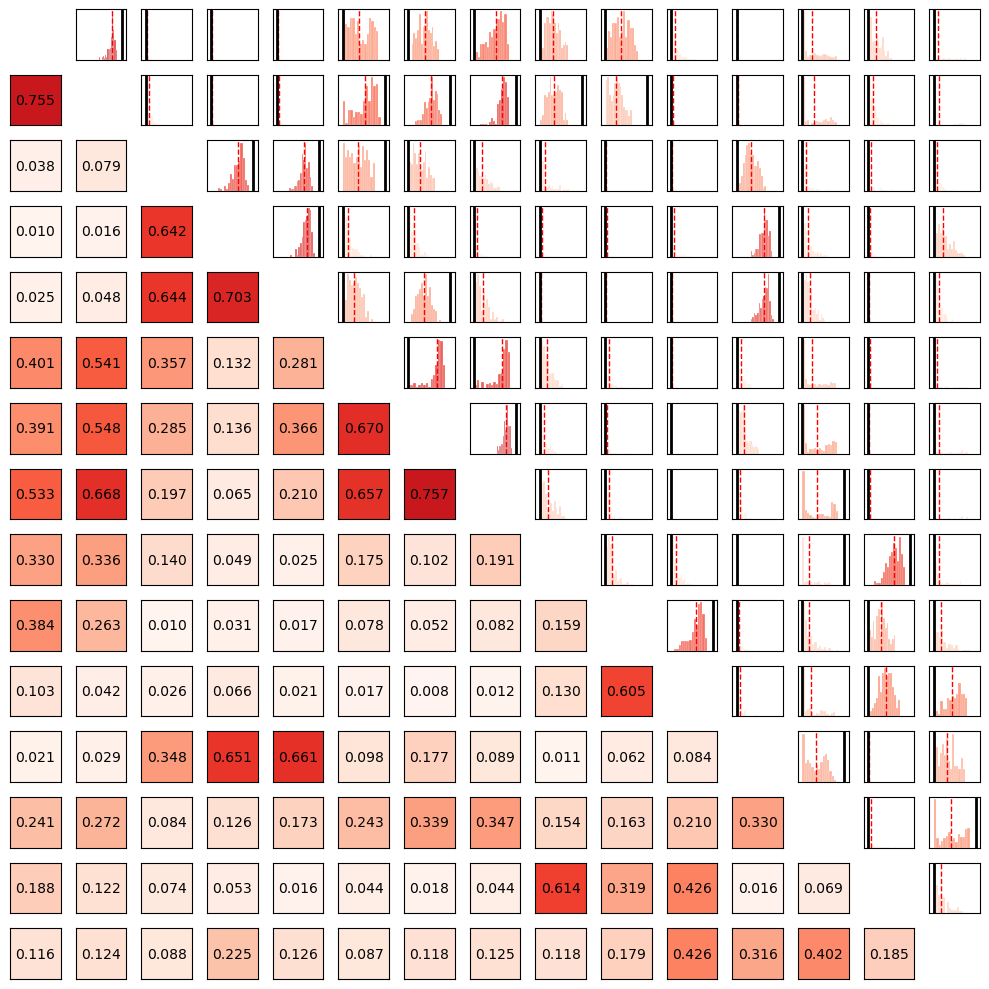

In [ ]:
plot_pairwise_sociomatrix(G,samples_Z, samples_a, samples_b, Y)

#### Model comparison criteria

In [ ]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a, samples_b)
waic = compute_WAIC(log_lik)
dic = compute_DIC_S1(log_lik, Y, samples_Z, samples_a, samples_b)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 200.0382
DIC: 71.3266


#### Prior predictive checking

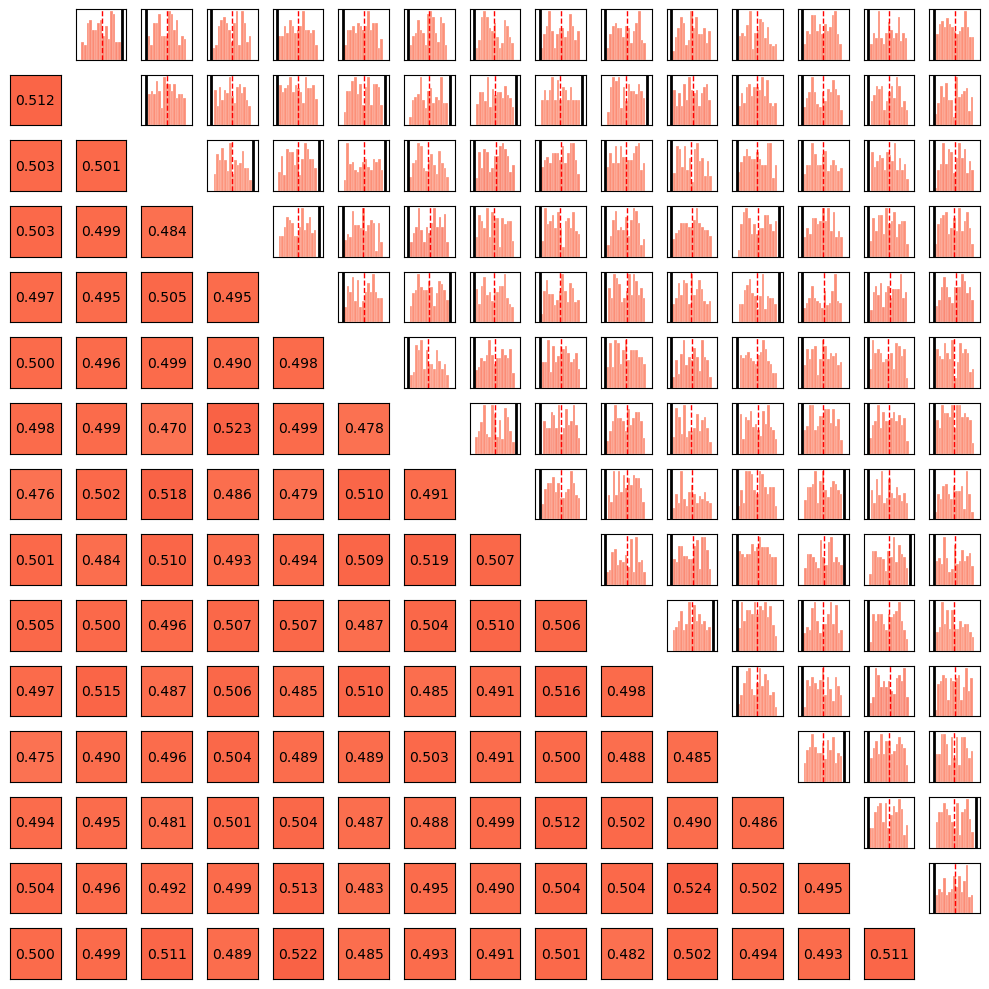

In [ ]:
angles_prior = 2*np.pi*np.random.rand(number_of_samples, n)
samples_Z_prior = np.stack((np.cos(angles_prior), np.sin(angles_prior)), axis=2)
samples_a_prior = np.random.randn(number_of_samples)
samples_b_prior = np.random.randn(number_of_samples)
plot_pairwise_sociomatrix(G,samples_Z_prior, samples_a_prior, samples_b_prior, Y)

#### Prediction evaluation

In [13]:
roc_analysis(Y, posterior_connection_probs(samples_Z, samples_a, samples_b))

ValueError: Input contains NaN.

## References

[1]